In [1]:
"""
Example control_approx_linearization.py
Author: Joshua A. Marshall <joshua.marshall@queensu.ca>
GitHub: https://github.com/botprof/agv-examples
Student: Dimitria Silveria
"""


'\nExample control_approx_linearization.py\nAuthor: Joshua A. Marshall <joshua.marshall@queensu.ca>\nGitHub: https://github.com/botprof/agv-examples\nStudent: Dimitria Silveria\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mobotpy.models import Articulated
from mobotpy.integration import rk_four
from scipy import signal

In [3]:
# Set the simulation time [s] and the sample period [s]
SIM_TIME = 15.0
T = 0.04

In [4]:
# Create an array of time values [s]
t = np.arange(0.0, SIM_TIME, T)
N = np.size(t)

In [5]:
# COMPUTE THE REFERENCE TRAJECTORY

#distance between the two carts axis and the central axis
a = 1.975
b = 3.850

#desired speed
v = 7.05

#straight line inclination

theta = np.pi/5



In [6]:
# Pre-compute the desired trajectory
x_d = np.zeros((4, N))
u_d = np.zeros((2, N))
for k in range(0, N):
    x_d[0, k] = v*np.cos(theta) * t[k]
    x_d[1, k] = v*np.sin(theta)*t[k]#m*(x_d[0,k])
    x_d[2, k] = theta
    x_d[3, k] = 0
    u_d[0, k] = v
    u_d[1, k] = 0



In [7]:
# VEHICLE SETUP
ell_W_r = ell_W_f = 1.0 #vehicle width

# Set the track length of the vehicle [m]
ell_T_r = b
ell_T_f = a
# Create a vehicle object of type DiffDrive
vehicle = Articulated(ell_W_r, ell_T_r, ell_W_f, ell_T_f)

In [10]:
# SIMULATE THE CLOSED-LOOP SYSTEM

# Initial conditions
x_init = np.zeros(4)
x_init[0] = 0.0
x_init[1] = 0.0
x_init[2] = np.pi/2
x_init[3] = 0

In [11]:
# Setup some arrays
x = np.zeros((4, N))
u = np.zeros((2, N))
x[:, 0] = x_init

In [12]:
for k in range(1, N):

    # Simulate the differential drive vehicle motion
    x[:, k] = rk_four(vehicle.f, x[:, k - 1], u[:, k - 1], T)
    # Compute the approximate linearization
    C = (u_d[0, k - 1]*b*np.cos(x_d[3,k - 1]) + b*a*u_d[1,k - 1]*np.sin(x_d[3,k - 1]) + a*u_d[0, k - 1])/(b+a*np.cos(x_d[3,k - 1]))**2
    A = np.array(
        [
            [0, 0, -u_d[0, k - 1] * np.sin(x_d[2, k - 1]),0],
            [0, 0, u_d[0, k - 1] * np.cos(x_d[2, k - 1]),0],
            [0, 0, 0,C],
            [0,0,0,0]
        ]
    )
    B = np.array([[np.cos(x_d[2, k - 1]), 0], [np.sin(x_d[2, k - 1]), 0], 
                  [np.sin(x_d[3, k - 1])/(b+a*np.cos(x_d[3,k - 1])), b/(b+a*np.cos(x_d[3,k - 1]))], [0, 1]])

    # Compute the gain matrix to place poles of (A-BK) at p
    p = np.array([-1.1, -2.0, -0.5, -0.5])
    K = signal.place_poles(A, B, p)

    # Compute the controls (v, omega) and convert to wheel speeds (v_L, v_R)
    u[:,k] = -K.gain_matrix @ (x[:, k - 1] - x_d[:, k - 1]) + u_d[:, k - 1]
    #u[:, k] = vehicle.uni2diff(u_unicycle)


In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

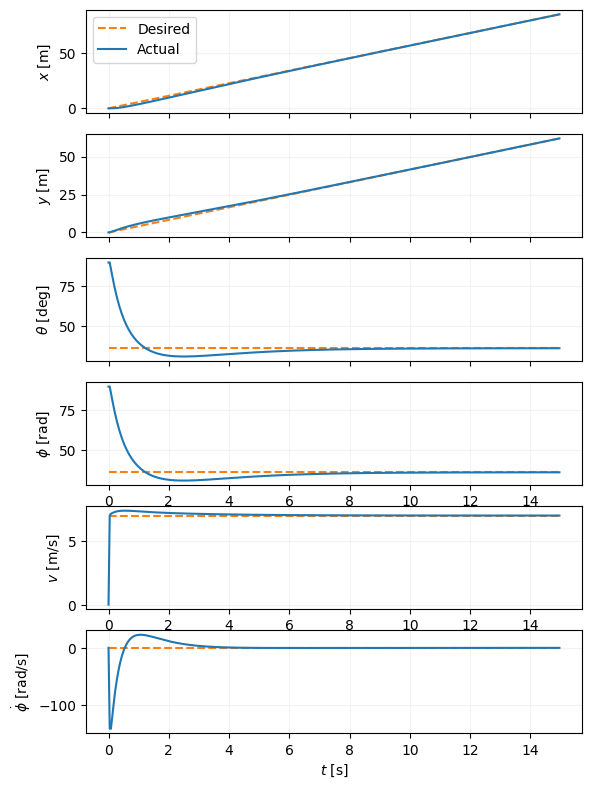

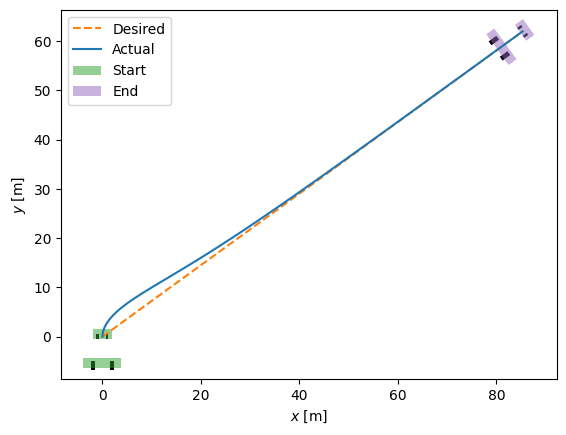

In [14]:
# MAKE PLOTS

# Change some plot settings (optional)
#plt.rc("text", usetex=True)
#plt.rc("text.latex", preamble=r"\usepackage{cmbright,amsmath,bm}")
# plt.rc("savefig", format="pdf")
# plt.rc("savefig", bbox="tight")

# Plot the states as a function of time
fig1 = plt.figure(1)
fig1.set_figheight(9.4)
ax1a = plt.subplot(611)
plt.plot(t, x_d[0, :], "C1--")
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$x$ [m]")
plt.setp(ax1a, xticklabels=[])
plt.legend(["Desired", "Actual"])
ax1b = plt.subplot(612)
plt.plot(t, x_d[1, :], "C1--")
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$y$ [m]")
plt.setp(ax1b, xticklabels=[])
ax1c = plt.subplot(613)
plt.plot(t, x_d[2, :]*180/np.pi, "C1--")
plt.plot(t, x[2, :]*180 / np.pi, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\theta$ [deg]")
plt.setp(ax1c, xticklabels=[])
ax1d = plt.subplot(614)
#v1 is v and v2 is phi dot
plt.plot(t, x_d[2, :]*180/np.pi, "C1--")
plt.plot(t, x[2, :]*180 / np.pi, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\phi$ [rad]")
plt.xlabel(r"$t$ [s]")
ax1e = plt.subplot(615)
plt.plot(t, u_d[0, :], "C1--")
plt.plot(t, u[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax1c, xticklabels=[])
ax1f = plt.subplot(616)
#v1 is v and v2 is phi dot
plt.plot(t, u_d[1, :]*180/np.pi, "C1--")
plt.plot(t, u[1, :]*180 / np.pi, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\dot\phi$ [rad/s]")
plt.xlabel(r"$t$ [s]")

# Save the plot
#plt.savefig("../agv-book/figs/ch4/control_approx_linearization_fig1.pdf")

# Plot the position of the vehicle in the plane
fig2 = plt.figure(2)
plt.plot(x_d[0, :], x_d[1, :], "C1--", label="Desired")
plt.plot(x[0, :], x[1, :], "C0", label="Actual")
plt.axis("equal")
X_L, Y_L, X_R, Y_R, X_BD, Y_BD, X_LR, Y_LR, X_RR, Y_RR, X_BDR, Y_BDR= vehicle.draw(x[0, 0], x[1, 0], x[2, 0],x[3, 0])
plt.fill(X_L, Y_L, "k")
plt.fill(X_R, Y_R, "k")
plt.fill(X_LR, Y_LR, "k")
plt.fill(X_RR, Y_RR, "k")
plt.fill(X_BD, Y_BD, "C2", alpha=0.5, label="Start")
plt.fill(X_BDR, Y_BDR, "C2", alpha=0.5)
X_L, Y_L, X_R, Y_R, X_BD, Y_BD, X_LR, Y_LR, X_RR, Y_RR, X_BDR, Y_BDR = vehicle.draw(
    x[0, N - 1], x[1, N - 1], x[2, N - 1], x[3, N - 1]
)
plt.fill(X_L, Y_L, "k")
plt.fill(X_R, Y_R, "k")
plt.fill(X_LR, Y_LR, "k")
plt.fill(X_RR, Y_RR, "k")
plt.fill(X_BD, Y_BD, "C4", alpha=0.5, label="End")
plt.fill(X_BDR, Y_BDR, "C4", alpha=0.5)
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$y$ [m]")
plt.legend()

# Save the plot
#plt.savefig("../agv-book/figs/ch4/control_approx_linearization_fig2.pdf")

# Show all the plots to the screen
plt.show()